# System Identification with Machine Learning Models - Part 1
> Simple prediction models that can be used for data augmentation

- toc: true 
- badges: true
- comments: true
- categories: [Prediction]

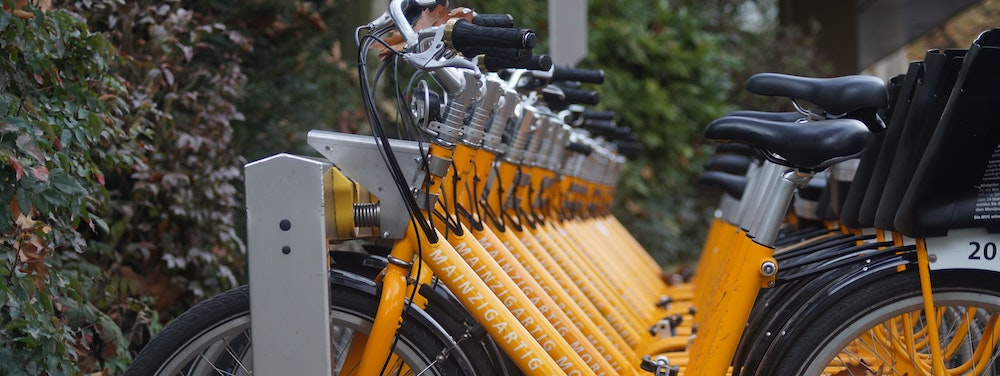
<span>Photo by <a href="https://unsplash.com/@millerthachiller?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Pascal Müller</a> on <a href="https://unsplash.com/s/photos/bike-sharing?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>



Recently, I have been looking at ways to create synthetic datasets, specificaly from timeseries given a real measured dataset using Machine Learning models. So, the basic idea is to use ML models for system identifiction. That means to characterize the dynamics of a system using measurements of the inputs and outputs of the system.

> One of the most popular non-linear system identification approach is based on the application of the Artificial Neural Networks (ANNs) (Gupta et al., 2003; Mueller and Lemke, 2000; Nelles, 2001)

Typically, in a dynamic system the values of the output variables depend on both the instantaneous values of the input variables and also on the past behavious of the system.

In this notebook (part 1 of upcoming notebook posts), I'll start with simple ML models that only take into account the instantaneous values of the input variables. For this purpose, I searched through Kaggle and picked a time series dataset that has seasonal and environmental input variables. The dataset is [Bike Share Daily Data](https://www.kaggle.com/contactprad/bike-share-daily-data) from Hadi Fanaee-T, Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto.


## Bike Share Daily Dataset 
Here is the description of the dataset according to their Kaggle page:

> Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com.

And here is the description of the fields in the dataset: 

- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In this notebook, we will train a model that characterize the dynamics of bike rental behaviour given the environmental and seasonal settings. We can look at this as a prediction problem where we try to predict the bike user counts (casual and registered) given the input data. 

After a short EDA and data preparation, we'll be using Gradient Boosting, Random Forest, and a simple DNN for this prediction and modeling problem.  

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import tensorflow as tf

## Loading the data

According to the description of the dataset, the enviromental features (4 columns of temp, atemp, hum and windspeed) are normalized. Since, we will standardize all continuous valued features later, we can reverse the normalization and turn according to the description below from the dataset owner:

- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)

In [12]:
df = pd.read_csv('bike_sharing_daily.csv', index_col ='dteday')
df.drop('instant', axis=1, inplace=True)
df['temp'] = df['temp']*41
df['atemp'] = df['atemp']*50
df['hum'] = df['hum']*100
df['windspeed'] = df['windspeed']*100
df


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,16.0446,331,654,985
2011-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,24.8539,131,670,801
2011-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,24.8309,120,1229,1349
2011-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,16.0296,108,1454,1562
2011-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,18.6900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,35.0133,247,1867,2114
2012-12-28,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,15.5471,644,2451,3095
2012-12-29,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,12.4383,159,1182,1341


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,20.310776,7.505091,2.424346,13.820424,20.431653,26.872076,35.328347
atemp,731.0,23.717699,8.148059,3.953480,16.892125,24.336650,30.430100,42.044800
hum,731.0,62.789406,14.242910,0.000000,52.000000,62.666700,73.020850,97.250000


## Any missing data? 


Good, there is no missing data. 

In [14]:
df.isnull().values.any()

False

## Visualization of time series

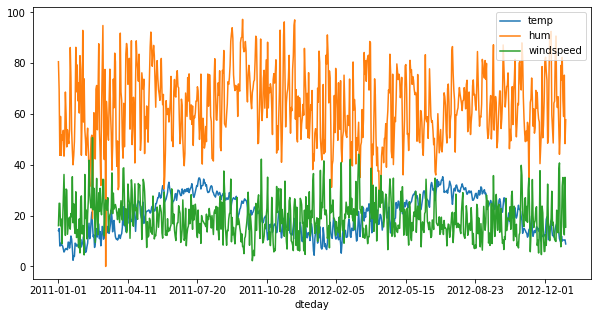

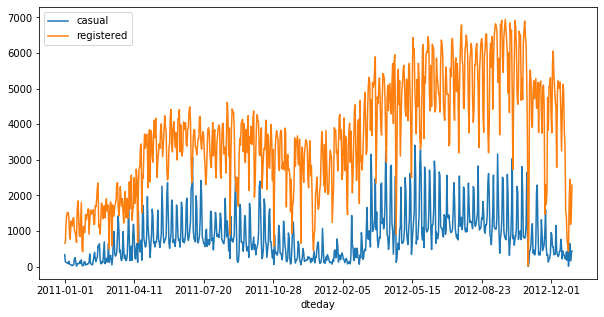

In [15]:
df[['temp', 'hum', 'windspeed']].plot(figsize=(10, 5))
df[['casual', 'registered']].plot(figsize=(10, 5))

## Cross Correlation Matrix

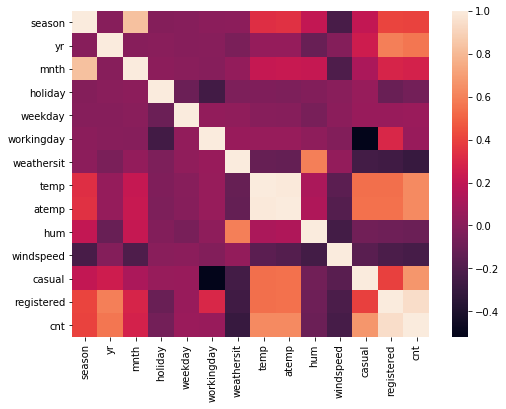

In [16]:
plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr())

I think the temp and atemp (feels like temperature) columns are too correlated, so perhaps we can discard atemp here. 


## Split the data
Let's make a simple manual split for now.

In [17]:
n = len(df)
train_df = df[:int(0.8*n)].copy()
test_df = df[int(0.8*n):].copy()

## Normalize the data
We just need to normalize the non-categorical data. So, first we define them and then normalize those columns only.

In [18]:
non_cat = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
train_mean = train_df[non_cat].mean()
train_std = train_df[non_cat].std()

train_df.loc[:, non_cat] = (train_df.loc[:, non_cat] - train_mean) / train_std
test_df.loc[:, non_cat] = (test_df.loc[:,non_cat] - train_mean) / train_std


Let's plot the probability density of the data using violin data to make sure our normalization looks good.

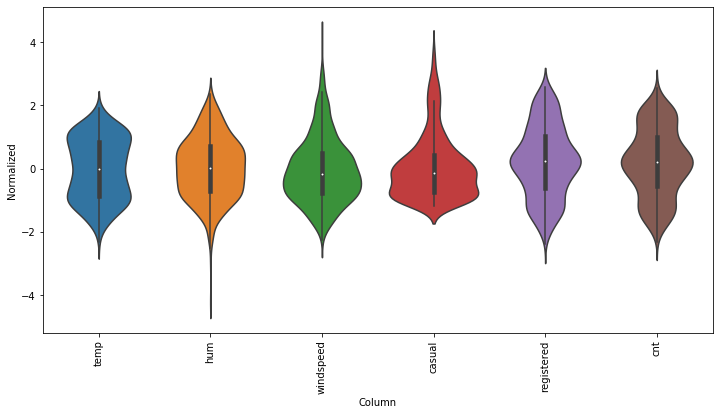

In [19]:
df_std = (df[non_cat] - train_mean) / train_std
df_melt = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_melt)
_ = ax.set_xticklabels(df[non_cat].keys(), rotation=90)

## Feature selection

There are two types of input data:
- Seasonal data
- Weather data

and the output of the model is the bike user count which can be found in three columns of:

- casual 
- registered
- cnt (sum of the causual and registered)

We can drop 'cnt' as it's just the total count of users. I experimented with seasonal data only or weather data only as the input to the model. But, the performance was better when all input features are used.

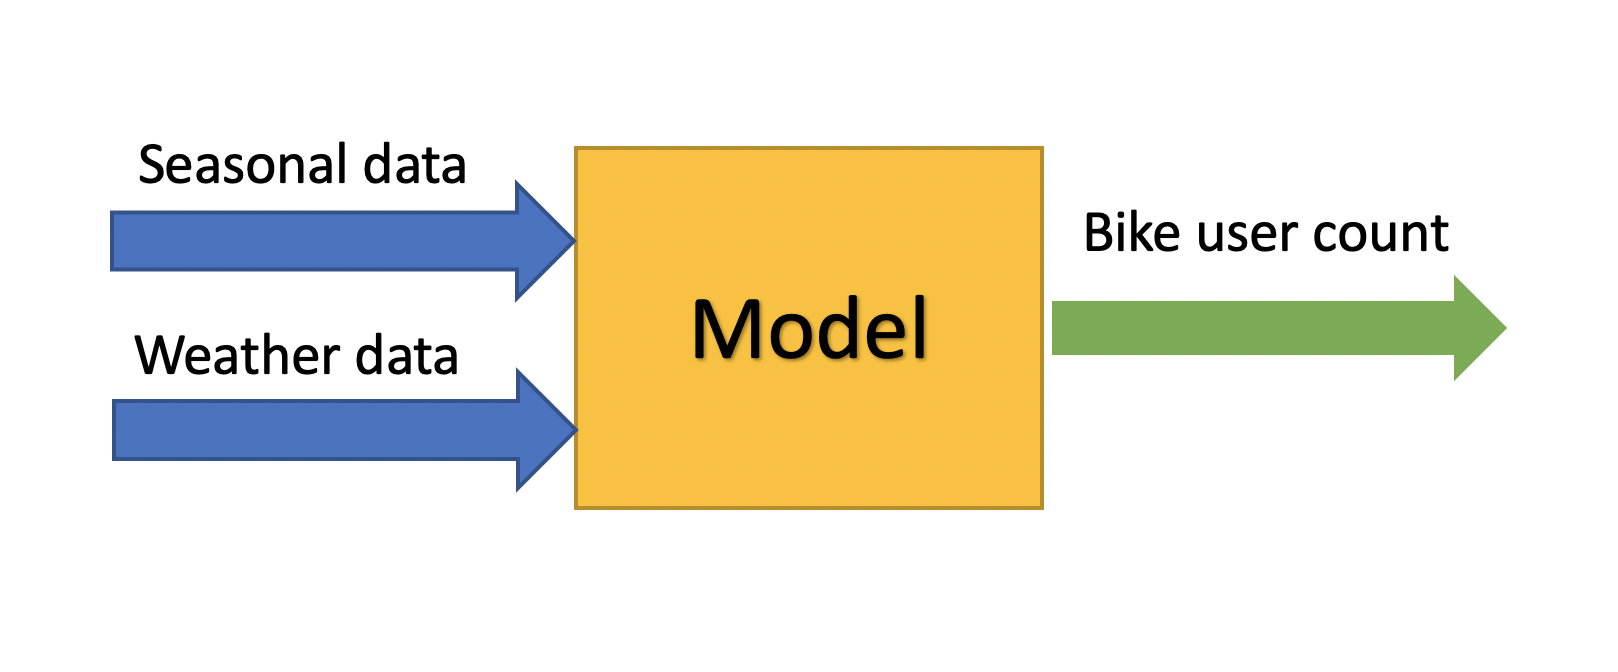

In [20]:
# separate input and output in each dataset
input_columns = ['season', 'yr', 'mnth', 'weekday', 'workingday','temp', 'hum', 'windspeed']
output_columns = ['casual', 'registered']



train_in = train_df[input_columns].to_numpy()
test_in = test_df[input_columns].to_numpy()


train_out = train_df[output_columns].to_numpy()
test_out = test_df[output_columns].to_numpy()

print(f'train_in shape: {train_in.shape}')
print(f'test_in shape: {test_in.shape}')
print(f'train_out shape: {train_out.shape}')
print(f'test_out shape: {test_out.shape}')

train_in shape: (584, 8)
test_in shape: (147, 8)
train_out shape: (584, 2)
test_out shape: (147, 2)


## Denormalizing function

Before evaluating the models, we invert the normalization and compare the predictions and true values in their actual scale. We use the following function to invert the normalization.

In [21]:
# mean and std to be used for inverting the normalizatioin
_mean = train_mean[output_columns].values
_std = train_std[output_columns].values

# Denormalize the data
def denorm(data, mean, std):
    data_denorm = data * std + mean
    return data_denorm


## Models

Let's define a function to evaluate the models.

In [22]:
def evaluate_model(model, train_in, train_out, test_in, test_out):
    print('\n***** Training performance: *****') 
    train_pred = model.predict(train_in)
    train_pred_denorm = denorm(train_pred, _mean, _std) 
    train_out_denorm = denorm(train_out, _mean, _std) 
    train_mae = round(mean_absolute_error(train_pred_denorm, train_out_denorm), 2)
    print('MAE = ', train_mae)


    print('\n***** Testing performance: *****') 
    test_pred = model.predict(test_in)
    test_pred_denorm = denorm(test_pred, _mean, _std) 
    test_out_denorm = denorm(test_out, _mean, _std) 
    test_mae = round(mean_absolute_error(test_pred_denorm, test_out_denorm), 2)
    print('MAE = ', test_mae)

    for i, col in enumerate(output_columns):   
        plt.figure(figsize=(10,5))
        plt.plot(test_pred_denorm[:, i])
        plt.plot(test_out_denorm[:, i])
        plt.legend(['predict', 'true'])
        plt.title(f'Predict vs. ground truth for {col}')
    return train_mae, test_mae

## Gradient Boosting


====== GradientBoostingRegressor =====

***** Training performance: *****
MAE =  165.58

***** Testing performance: *****
MAE =  515.7


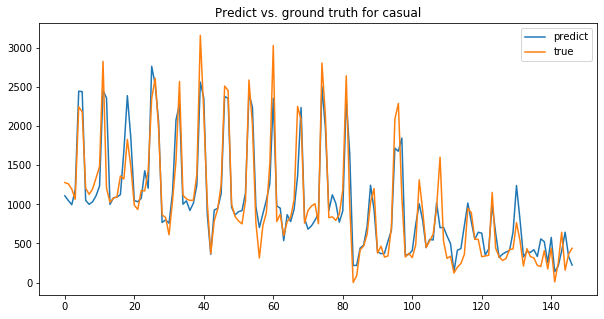

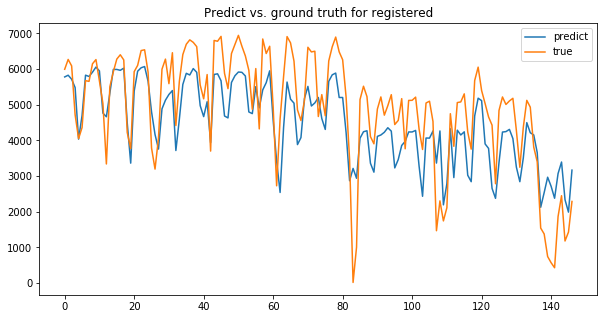

In [23]:
# Creating a MultiOutputRegressor object with GradientBoostingRegressor estimtor 
# This assumes that the outputs are independent of each other, which might not be a correct assumption. 
gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=0))

print('\n====== GradientBoostingRegressor =====')
gbr.fit(train_in, train_out) 
gbr_train_mae, gbr_test_mae = evaluate_model(gbr, train_in, train_out, test_in, test_out)

## Random Forest


====== RandomForestRegressor =====

***** Training performance: *****
MAE =  97.21

***** Testing performance: *****
MAE =  548.42


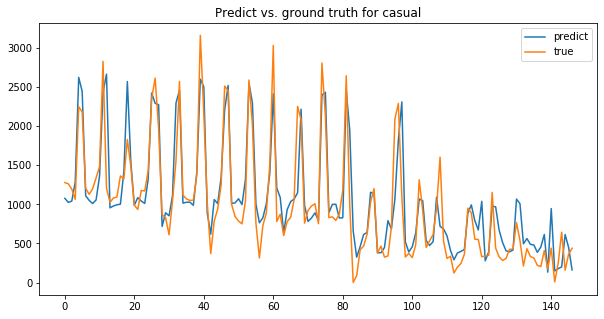

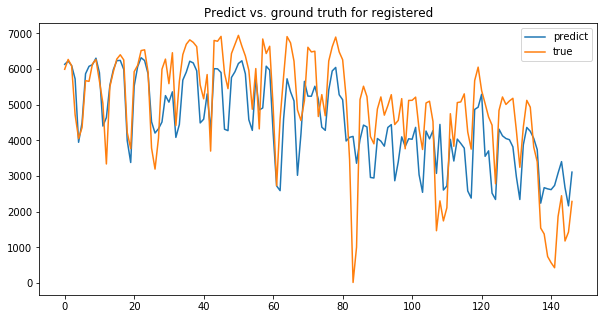

In [24]:
rfr = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
print('\n====== RandomForestRegressor =====')
rfr.fit(train_in, train_out) 
rfr_train_mae, rfr_test_mae = evaluate_model(rfr, train_in, train_out, test_in, test_out)

## DNN

In [25]:
nn = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(len(input_columns),)),
    tf.keras.layers.Dense(len(output_columns))
])

print(nn.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 354
Trainable params: 354
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
MAX_EPOCHS = 100

def compile_and_fit(model, train_in, train_out, test_in, test_out, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train_in, train_out, epochs=MAX_EPOCHS,
                      validation_data=(test_in, test_out),
                      callbacks=[early_stopping],
                      batch_size = 32, verbose=0)
    return history

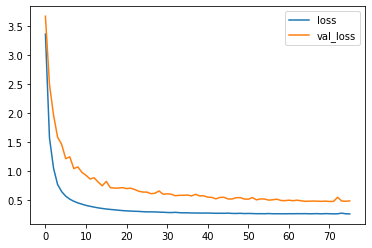

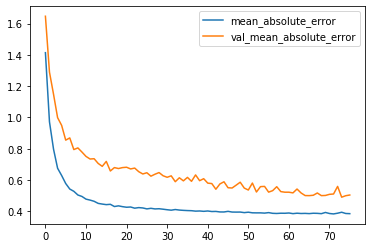

In [27]:
tf.keras.backend.clear_session()
history = compile_and_fit(nn, train_in, train_out, test_in, test_out)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.figure()
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])


***** Training performance: *****
MAE =  384.11

***** Testing performance: *****
MAE =  559.46


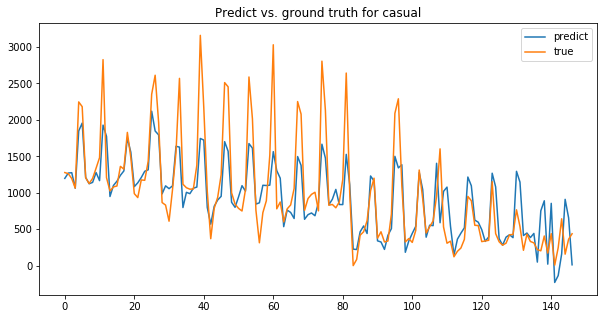

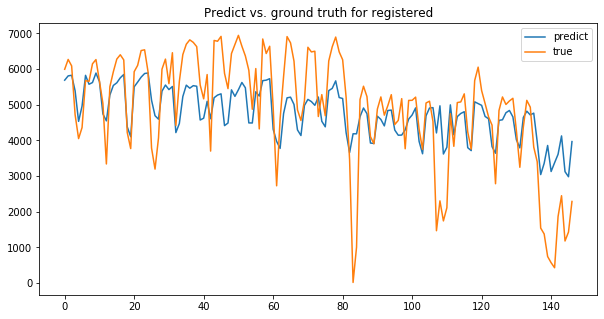

In [28]:
nn_train_mae, nn_test_mae = evaluate_model(nn, train_in, train_out, test_in, test_out)

## Comparing the models

In [29]:
print('Model: Train MAE - Test MAE')
print(f'Gradient Boosting: {gbr_train_mae} - {gbr_test_mae }')
print(f'Random Forest: {rfr_train_mae} - {rfr_test_mae }')
print(f'DNN: {nn_train_mae} - {nn_test_mae }')


Model: Train MAE - Test MAE
Gradient Boosting: 165.58 - 515.7
Random Forest: 97.21 - 548.42
DNN: 384.11 - 559.46


It looks like the best results based on test MAE is driven from Gradient Boosting method. Perhaps the other models specially DNN can be tuned to achieve at least the same level of performance. Please let me know if you have any suggestion to improve the models. Thanks for your feedback.